# Training Sequential Circuits with Pytorch

This notebook shows the expands upon the sequential circuits structure <br>
and optimize the circuit using PyTorch.

In [2]:
# !pip install pennylane
# !pip install pennylane-lightning

In [3]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates.embeddings import AmplitudeEmbedding
from model import Conv1DLayer, PoolingLayer, unitarity_conv1d, unitarity_pool, unitarity_toffoli
import torch

# Defining the device

In [4]:
#Specify how many wires will be used
num_wires = 12
num_ancilla = 4
num_work_wires = num_wires - num_ancilla
#Specify what type of device you are using.
#device_type = 'default.qubit'
#device_type = 'default.qubit.torch'
device_type = 'lightning.qubit'

#Initialize Device
dev = qml.device(device_type, wires=num_wires) 

# Defining circuit to be trained

In [5]:
def circuit(num_wires, num_ancilla):
    @qml.qnode(dev, interface='torch', diff_method ='adjoint')
    def func(inputs, params): 
        work_wires = list(range(num_wires - num_ancilla))
        ancilla_wires = list(range(len(work_wires),num_wires))

        # Data Embedding Layer
        AmplitudeEmbedding(inputs , wires=work_wires , normalize=True)

        # Hidden Layers
        work_wires , params = Conv1DLayer(unitarity_conv1d , 15)(work_wires , params)
        work_wires , params = PoolingLayer(unitarity_pool , 2)(work_wires , params)
        work_wires , params = Conv1DLayer(unitarity_conv1d , 15)(work_wires , params)
        work_wires , params = PoolingLayer(unitarity_pool , 2)(work_wires , params)

        #Toffili Structure
        unitarity_toffoli(work_wires,ancilla_wires)

        return [qml.expval(qml.PauliZ(wire)) for wire in ancilla_wires]
    return func

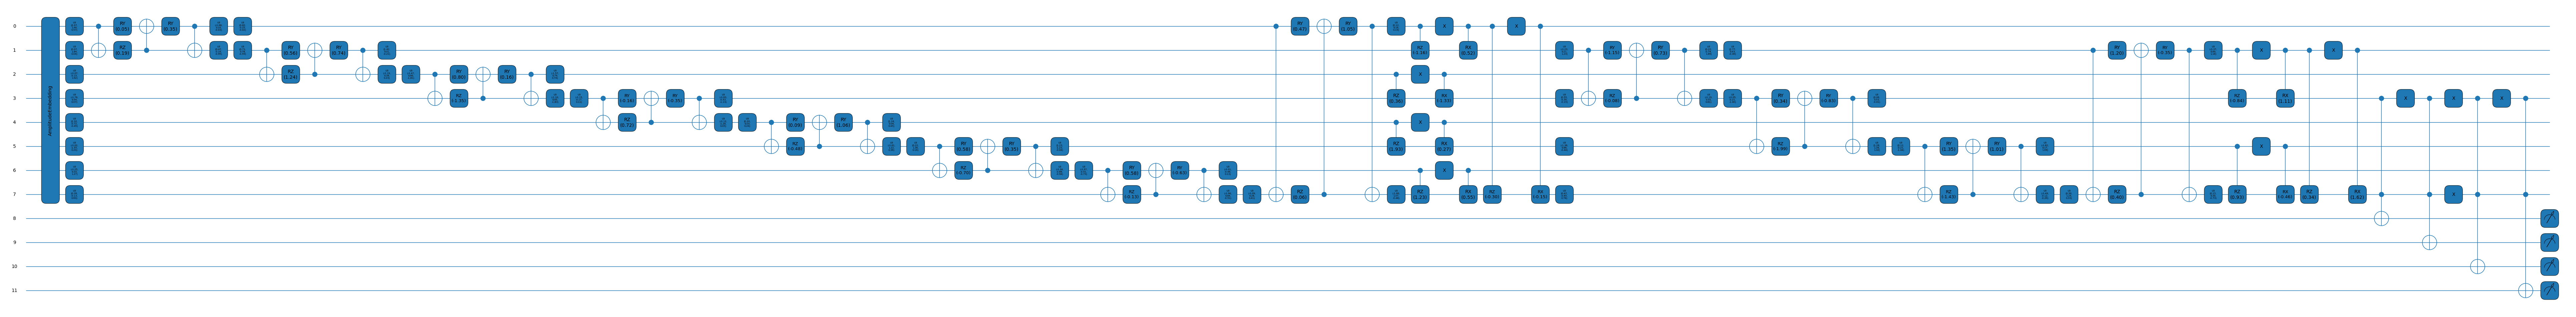

In [6]:
# x is the encoded date sized to an array of x length, where x = 2^qubits.
embedding_size = 2**num_work_wires
dummy_embedding = [1] * embedding_size

# Initializing parameters, this based off the unitarity, and model structure. 
params = np.random.normal(loc=0.0, scale=1.0, size = 357)

from matplotlib import pyplot as plt
fig, ax = qml.draw_mpl(circuit(num_wires, num_ancilla), decimals=2)(dummy_embedding, params)
plt.show()

# Import training Data

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
batch_size = 32
embedding_size = 2**num_work_wires
labels = [0,1,2,3]  #,4,5,6,7]
num_labels = len(labels)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((16,16)),
    transforms.Lambda(lambda x: torch.reshape(x, (-1,))),
])

reverse_transform = transforms.Compose([
    transforms.Lambda(lambda x: torch.reshape(x, (-1,16,16))),
    transforms.Resize((28,28)),
])

train_data = datasets.MNIST(
    root='./dataset/F_MNIST_DATA/',
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.MNIST(
    root='./dataset/F_MNIST_DATA/',
    train=False,
    download=True,
    transform=transform
)

#Filter for classes 
train_idx = [i for i, y in enumerate(train_data.targets) if y in labels]
train_data = torch.utils.data.Subset(train_data, train_idx)

test_idx = [i for i, y in enumerate(test_data.targets) if y in labels]
test_data = torch.utils.data.Subset(test_data, test_idx)

# Pytorch loader
train_loader = DataLoader(
    dataset=train_data,
    shuffle=True,
    batch_size=batch_size,
    drop_last = True
)

# Pytorch loader
test_loader = DataLoader(
    dataset=train_data,
    shuffle=False,
    batch_size=batch_size,
    drop_last = False
)

# Preparing the circuit for PyTorch

In [8]:
params_shapes = {"params": 357} #{parameters_name: number of params}
qlayer = qml.qnn.TorchLayer(circuit(num_wires, num_ancilla), params_shapes,torch.nn.init.normal_) 
output = torch.nn.Softmax(dim=1)

In [9]:
# Defining the model
model = torch.nn.Sequential(qlayer,output)

#Move model to GPU device (Recommend only if qubits > 15)
#model = model.to(device=torch.device('cuda:0'))

# Defining the loss function
loss = torch.nn.CrossEntropyLoss()

# Training our model

In [10]:
# Hyperparameters
epochs = 8
batch_size = 32
train_samples = len(train_data)
batches = train_samples // batch_size

In [11]:
from tqdm.notebook import tqdm, trange

opt = torch.optim.Adam(model.parameters(), lr=0.001)
#opt = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(epochs):
    
    running_loss = 0
    batch = 0
    model.train()
    
    for batch, i in zip(train_loader,trange(batches)):
        data = batch[0]
        target = batch[1]      
        #data, target = data.to('cuda:0'), target.to('cuda:0')
                
        opt.zero_grad()
        pred = model(data)
        loss_evaluated = loss(pred, target)
        loss_evaluated.backward()
        opt.step()
        running_loss += loss_evaluated
        print(running_loss.item() / (i + 1), end ='\r')
        
    avg_loss = running_loss / batches
    res = [epoch + 1,avg_loss]
    print("Epoch: {:2d} | Loss: {:3f} ".format(*res))

  0%|          | 0/773 [00:00<?, ?it/s]

Epoch:  1 | Loss: 1.351320 


  0%|          | 0/773 [00:00<?, ?it/s]

Epoch:  2 | Loss: 1.329192 


  0%|          | 0/773 [00:00<?, ?it/s]

Epoch:  3 | Loss: 1.323789 


  0%|          | 0/773 [00:00<?, ?it/s]

Epoch:  4 | Loss: 1.320621 


  0%|          | 0/773 [00:03<?, ?it/s]

Epoch:  5 | Loss: 1.318544 


  0%|          | 0/773 [00:03<?, ?it/s]

Epoch:  6 | Loss: 1.317305 


  0%|          | 0/773 [00:02<?, ?it/s]

KeyboardInterrupt: 

# Evaluating the model

In [13]:
# since we're not training, we don't need to calculate the gradients for our outputs
correct = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        data = batch[0]
        target = batch[1]
        #print(target)
        # calculate outputs by running images through the network
        predicted = model(data)
        
        # the class with the highest energy is what we choose as prediction
        predicted = torch.argmax(predicted, 1)

        total += target.size(0)
        
        correct += (predicted == target).sum().item()
        print(100 * correct / total, end = '\r')

print('Accuracy of the network on {:2d} test images: {:.3f} %'.format(total,(100 * correct / total)))

Accuracy of the network on 24754 test images: 86.774 %


In [14]:
import os
PATH = os.getcwd() + '/qcnn_fmnist'
print(PATH)

/home/ec2-user/SageMaker/qauntum-deep-learning/qauntum-deep-learning/qcnn_fmnist


In [15]:
torch.save(model.state_dict(), PATH)

In [16]:
model = torch.nn.Sequential(qlayer,output)
model.load_state_dict(torch.load(PATH))
model.eval()

Sequential(
  (0): <Quantum Torch Layer: func=func>
  (1): Softmax(dim=1)
)